各位朋友好,今天我给大家介绍一个国外深度学习大牛Jason Brownlee写的一篇关于多变量时间序列预测的博客，我在原文的代码基础上做了一点点修改，只是为了便于大家更好的理解。在本文中，您将了解如何在Keras深度学习库中为多变量时间序列预测开发LSTM模型。读完成本文后，您将了解：

* 如何将原始数据集转换为可用于时间序列预测的数据。
* 如何准备数据并使LSTM适合多变量时间序列预测问题。
* 如何进行预测并将结果重新调整回原始单位。

# 空气污染的预测

在本文中，我们将使用空气质量数据集。

这个数据集来自于在美国驻中国大使馆收集的北京五年的每小时的空气质量数据。

数据包括日期时间，PM2.5浓度，以及包括露点，温度，气压，风向，风速和累积的下雪小时数的天气信息。原始数据中的完整功能列表如下：

* No : 行号
* year,month,day,hour : 表示年，月，日，小时
* pm2.5 : pm2.5污染浓度
* DEWP : 露点（空气中水气含量达到饱和的气温，低于此温度时水气从空气中析出凝成水珠） 
* TEMP : 温度
* PRES : 气压
* cbwd ：风向
* Iws ： 风速
* ls : 累积的下雪小时数
* lr : 累积的下小时数


我们可以使用这些数据并构建一个预测问题，我们想通过前一个小时的天气条件和pm2.5浓度，来预测下一个小时的pm2.5浓度。

你们可以在这里下载空气质量数据(https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv)

下面我们查看一下数据

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./data/pollution.csv')
print(len(df))
df.head(10)
print(df.year.unique())

43824
[2010 2011 2012 2013 2014]


从上面的数据中我们看到数据集中总共有43824条记录，时间是从2010至2014总共5年的数据，数据集中前n条数据的pm2.5的值是空值(NaN),下面我们要对数据做一些清洗工作，我们要合并年，月，日，小时并将其设置为索引例，同时删除原来的年,月,日,小时字段。

In [3]:
df['date']=df.apply(lambda x:datetime.datetime(x["year"], x["month"], x["day"],x["hour"]), axis=1)
df = df.set_index(['date'])
df.drop(['No','year','month','day','hour'], axis=1, inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


接下来我们重新命名数据集的字段名,并删除前24条pm2.5的值为空的记录

In [4]:
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df['pollution'].fillna(0, inplace=True)
# 删除前24小时的数据
df = df[24:]
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


下面我们对除风向(wnd_dir)以外的7个变量进行可视化，我们要查看一下它们的时序图

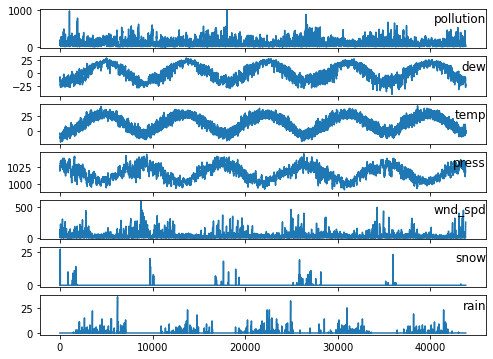

In [5]:
values = df.values
# 指定要可视化的例
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(8,6))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# 多变量LSTM预测模型

在目前这个应用场景中,我们的特征变量有7个(除pollution变量以外的所有变量)，而我们的目标变量只有一个(pollution)，我们想通过前一小时的7个特征变量来预测后一小时的污染浓度变量(pollution)，这就是一个典型的多变量时间序列预测的问题。下面我们要使用LSTM模型来解决这个多变量时间序列的预测问题。

## 为LSTM模型准备数据

这里将是本文的一个重点,目前的我们的数据集是一个时间序列数据集，它没有标签，接下来我们要做的就是将时间序列数据转换成监督学习的数据并且生成标签。然后对输入的变量进行标准化处理。 考虑到污染测量和前一时刻(t-1)的天气条件，我们将监督学习问题定为预测当前小时（t）的污染。

如何将时间序列数据转换成监督学习的数据？这里我们定义了一个函数:series_to_supervised(), 它通过数据平移的方式将我们的目标变量前移一个时间单位，这样就形成了数据的标签,有了标签它就变成了监督学习的数据，这样我们就可以训练lstm模型了。

In [6]:
# 将序列转换成监督式学习
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # 输入序列(t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # 将他们整合在一起
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 删除那些包含空值(NaN)的行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
values = df.values
#对风向字段进行编码
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 确保所有变量都是实数型
values = values.astype('float32')
#对数据进行标准化出来
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 将时间序列数据转换成监督学习数据
reframed = series_to_supervised(scaled, 1, 1)
# 删除那些不需要预测的列
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


从上面的输出结果中我们看见var(t-1)至var8(t-1)为我们的前一小时的特征变量，var1(t)为当前时刻t的目标变量，var(t)是var(t-1)进行一次数据平移所产生的结果。这样我们就可以利用t-1时刻的特征数据来预测t时刻污染浓度。

到目前为止我们已经有了特征集和标签，下面我们就可以为LSTM模型准备训练集和测试集了。由于这是时间序列的数据,t时刻的污染浓度和t-1时刻的天气条件是有密切关系的，所以在准训练集和测试集时，我们不能对原始数据进行乱序操作。这里我们要按顺序将第一年的数据作为训练集，将后面四年的数据作为测试集。然后我们将训练集和测试集转化成3维数组的格式。

In [8]:
# 将数据分割为训练集和测试集
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 分离出特征集与标签
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 转换成3维数组 [样本数, 时间步 ,特征数]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


我们可以看到，在训练集中我们用8千多个小时的数据用于训练模型，然后对3W多小时的测试数据进行预测和评估。

## 定义LSTM模型

我们将定义一个LSTM模型，在它的第一个隐藏层中有50个神经元，在输出层中有1个神经元用于预测污染浓度。输入数据的维度将是1个时间步(即1小时)和8个特征。

我们将使用平均绝对误差（MAE）损失函数和随机梯度下降的有效Adam版本。该模型的批量大小(batch_size)为72的50个训练周期。请记住，Keras中LSTM的内部状态在每个批次结束时重置，因此内部状态可能是天数的函数,这可能会对你有帮助。

最后，我们通过在fit()方法中设置validation_data参数来跟踪训练期间的训练和测试损失。在训练结束时，对训练和测试损失进行可视化。

In [9]:
# 创建模型
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

W0825 20:12:11.721156 140736170390400 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 20:12:11.740559 140736170390400 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 20:12:11.743970 140736170390400 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 20:12:11.969975 140736170390400 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


## 训练LSTM模型

W0825 20:12:12.231505 140736170390400 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0825 20:12:12.847187 140736170390400 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0825 20:12:12.953648 140736170390400 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0600 - val_loss: 0.0543
Epoch 2/50
 - 1s - loss: 0.0418 - val_loss: 0.0621
Epoch 3/50
 - 1s - loss: 0.0253 - val_loss: 0.0536
Epoch 4/50
 - 1s - loss: 0.0176 - val_loss: 0.0414
Epoch 5/50
 - 1s - loss: 0.0155 - val_loss: 0.0250
Epoch 6/50
 - 1s - loss: 0.0151 - val_loss: 0.0180
Epoch 7/50
 - 1s - loss: 0.0149 - val_loss: 0.0167
Epoch 8/50
 - 1s - loss: 0.0148 - val_loss: 0.0159
Epoch 9/50
 - 1s - loss: 0.0149 - val_loss: 0.0156
Epoch 10/50
 - 1s - loss: 0.0147 - val_loss: 0.0148
Epoch 11/50
 - 1s - loss: 0.0148 - val_loss: 0.0150
Epoch 12/50
 - 1s - loss: 0.0148 - val_loss: 0.0149
Epoch 13/50
 - 1s - loss: 0.0148 - val_loss: 0.0145
Epoch 14/50
 - 1s - loss: 0.0146 - val_loss: 0.0141
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0140
Epoch 16/50
 - 1s - loss: 0.0146 - val_loss: 0.0136
Epoch 17/50
 - 1s - loss: 0.0146 - val_loss: 0.0141
Epoch 18/50
 - 1s - loss: 0.0147 - val_loss: 0.0138
Epoch 19/50
 - 1s - loss

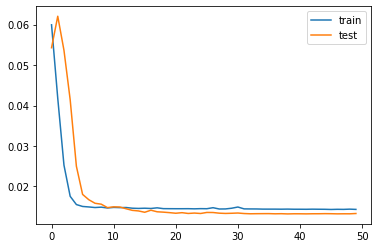

In [10]:
# 训练模型
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# 对损失进行可视化
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 评估LSTM模型

在模型训练结束后，我们可以预测整个测试数据集。

由于我们在训练模型之前已经将所有的特征集和标签进行了标准化处理即将数据值缩放到了0-1之间，因此我们的预测结果也是在0-1之间，为了对预测结果进行有效评估，我们必须将预测结果和标签值全部转换成没有标准处理之前的实际值，这样我们才能进行有效评估。

通过将预测结果和测试集的标签值进行逆向缩放，我们就得到了实际值，这样我们可以计算模型的误差分数。我们使用均方根误差(RMSE)作为评估指标。

In [11]:
# 对测试集进行预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# 对预测值进行逆标准处理
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 对测试集标签进行逆标准化处理
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# 计算 RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.404


# 完善LSTM模型:预测未来多天的污染浓度

前面这个模型我们是用t-1时刻的天气数据来预测t时刻的污染浓度,也就是说我们只能预测未来1小时的污染情况，有没有办法让我们的模型可以预测未来几个小时的空气污染情况呢？

为了解决预测未来n个小时的空气污染浓度，我们只要将原先的特征集平移n个时间步，例如我们要预测未来3小时的污染浓度，我们只需要调用series_to_supervised方法，并将参数n_in设置为3，就可以将特征集往前平移3个时间步。

In [12]:
# 设置预测未来3小时的污染
n_hours = 3
n_features = 8
# 将时间序列转换成监督学习数据集
reframed = series_to_supervised(scaled, n_hours, 1)

我们的数据集中有3 * 8 + 8列。我们将前24列作为前3小时(t-3,t-2,t-1)的特征。我们将在下一个小时(t)的污染变量作为标签，如下所示：

In [20]:
reframed.head(10)

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0
8,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.105634,0.485294,...,0.000000,0.0,0.120724,0.470588,0.213115,0.600000,0.666667,0.020610,0.000000,0.0
9,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0,0.124748,0.485294,...,0.000000,0.0,0.132797,0.485294,0.229508,0.618183,0.666667,0.023669,0.000000,0.0
10,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0,0.120724,0.470588,...,0.000000,0.0,0.140845,0.485294,0.229508,0.636364,0.666667,0.029018,0.037037,0.0
11,0.120724,0.470588,0.213115,0.600000,0.666667,0.020610,0.000000,0.0,0.132797,0.485294,...,0.037037,0.0,0.152918,0.470588,0.229508,0.636364,0.666667,0.034367,0.000000,0.0
12,0.132797,0.485294,0.229508,0.618183,0.666667,0.023669,0.000000,0.0,0.140845,0.485294,...,0.000000,0.0,0.148893,0.470588,0.229508,0.636364,0.666667,0.039716,0.000000,0.0


In [21]:
print(reframed.columns)

Index(['var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var1(t-2)', 'var2(t-2)',
       'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)',
       'var8(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)',
       'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)',
       'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)',
       'var8(t)'],
      dtype='object')


In [14]:
# 分离训练集和测试集
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [15]:
# 分离特征集和标签
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


接下来我们要讲训练数据和测试数据转换成3维数组格式，与之前的3维数组不一样的是，此时我们三维数组的第二个维度将是3。

In [16]:
# 转换成3维数据格式 [样本数, 时间步, 特征数]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

## 训练模型

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 2s - loss: 0.0466 - val_loss: 0.0677
Epoch 2/50
 - 1s - loss: 0.0278 - val_loss: 0.0547
Epoch 3/50
 - 1s - loss: 0.0221 - val_loss: 0.0297
Epoch 4/50
 - 1s - loss: 0.0211 - val_loss: 0.0239
Epoch 5/50
 - 1s - loss: 0.0204 - val_loss: 0.0225
Epoch 6/50
 - 1s - loss: 0.0201 - val_loss: 0.0200
Epoch 7/50
 - 1s - loss: 0.0197 - val_loss: 0.0185
Epoch 8/50
 - 1s - loss: 0.0192 - val_loss: 0.0181
Epoch 9/50
 - 1s - loss: 0.0187 - val_loss: 0.0179
Epoch 10/50
 - 1s - loss: 0.0183 - val_loss: 0.0175
Epoch 11/50
 - 1s - loss: 0.0180 - val_loss: 0.0170
Epoch 12/50
 - 1s - loss: 0.0176 - val_loss: 0.0166
Epoch 13/50
 - 1s - loss: 0.0173 - val_loss: 0.0159
Epoch 14/50
 - 1s - loss: 0.0168 - val_loss: 0.0157
Epoch 15/50
 - 1s - loss: 0.0166 - val_loss: 0.0160
Epoch 16/50
 - 1s - loss: 0.0160 - val_loss: 0.0158
Epoch 17/50
 - 1s - loss: 0.0157 - val_loss: 0.0156
Epoch 18/50
 - 1s - loss: 0.0155 - val_loss: 0.0155
Epoch 19/50
 - 1s - loss

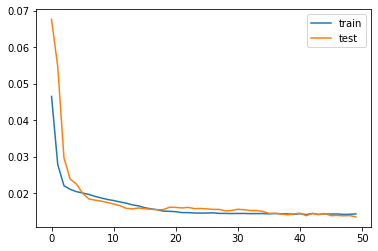

In [17]:
# 定义模型
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 训练模型
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# 可视化
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 评估模型

In [18]:
# 对测试集进行预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# 对预测数据进行逆标准化
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 对测试集标签进行逆标准化
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# 计算均方根误差
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.332
